# Wildfire Intensity Prediction Project

### Imports

In [44]:
import pandas as pd
import numpy as np

import itertools
import time
import matplotlib.pyplot as plt

# import missingno as msno
# import seaborn as sns

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf
import cvxopt

from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr

import folium
from folium.plugins import HeatMap

### Read and Preview Data

In [40]:
fire_data = pd.read_csv("clean_fire_data.csv")
fire_data = fire_data.drop(columns="Unnamed: 0")
print(fire_data.shape)
fire_data.head()

(1190, 21)


,ID,lat,lon,start_date,incident name,fully_contained,geographic_area,new,size,temp,...,pressure,humidity,dew_point,clouds,visibility,wind_speed,wind_deg,rain,weather,weather_description
0,19337,34.871,-94.666,2022-12-31 00:00:00,Pine_Mt._Fire,True,SAC,True,436.0,285.28,...,1015,58,277.27,0,10000.0,0.00,0,0.0,Clear,clear sky
1,19339,29.362,-82.600,2023-01-11 00:00:00,NE_CR_337,True,SAC,True,182.0,286.23,...,1020,74,281.71,0,NaN,3.18,272,0.0,Clear,clear sky
2,19340,33.203,-99.255,2023-01-11 00:00:00,Cellers_Hill,True,SAC,True,695.0,298.12,...,1009,10,265.39,100,NaN,4.63,249,0.0,Clouds,overcast clouds
3,19341,27.686,-81.934,2023-01-10 00:00:00,STREAMSONG,True,SAC,False,475.0,292.92,...,1020,78,288.98,1,NaN,1.34,313,0.0,Clear,clear sky
4,19343,35.296,-95.924,2023-01-14 00:00:00,RATTLESNAKE_HOLLOW,True,SAC,True,888.0,278.55,...,1029,62,272.01,89,NaN,1.84,45,0.0,Clouds,overcast clouds


### Preview columns

In [4]:
df = fire_data.copy()
print(df.info())
print()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   1190 non-null   int64  
 1   lat                  1190 non-null   float64
 2   lon                  1190 non-null   float64
 3   start_date           1190 non-null   object 
 4   incident name        1190 non-null   object 
 5   fully_contained      1190 non-null   bool   
 6   geographic_area      1189 non-null   object 
 7   new                  1190 non-null   bool   
 8   size                 1190 non-null   float64
 9   temp                 1190 non-null   float64
 10  feels_like           1190 non-null   float64
 11  pressure             1190 non-null   int64  
 12  humidity             1190 non-null   int64  
 13  dew_point            1190 non-null   float64
 14  clouds               1190 non-null   int64  
 15  visibility           287 non-null    f

In [5]:
# Missing Values?
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

geographic_area      1
visibility         903
dtype: int64

#### "Size"

Text(0, 0.5, 'log(Acres)')

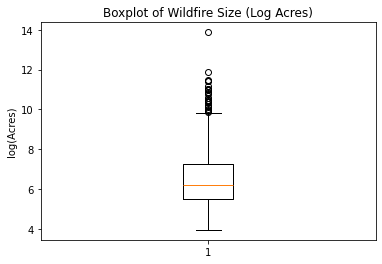

In [25]:
plt.boxplot(np.log(df['size']));
plt.title('Boxplot of Wildfire Size (Log Acres)')
plt.ylabel('log(Acres)')

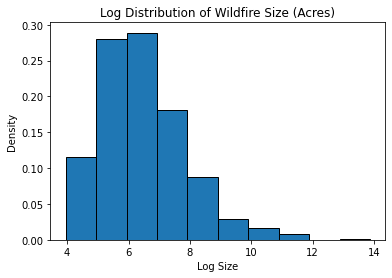

In [17]:
np.log(df['size']).plot(kind='hist', density=True, edgecolor='black')
plt.title(f'Log Distribution of Wildfire Size (Acres)')
plt.xlabel('Log Size')
plt.ylabel('Density')
plt.show()

### Univariate Analysis

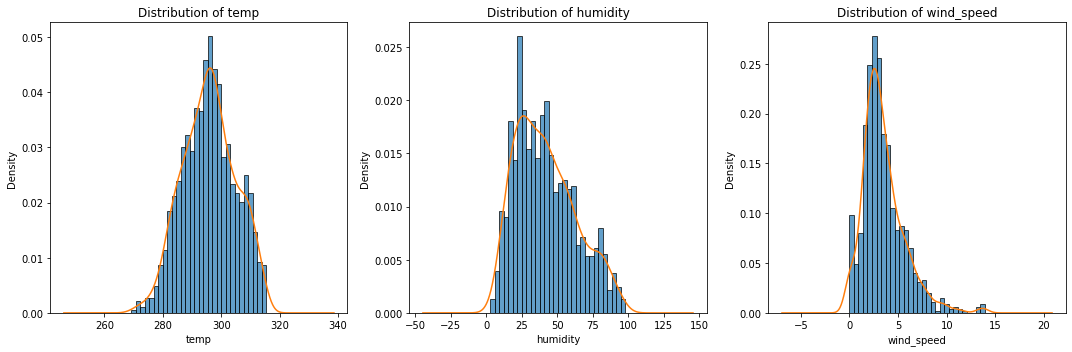

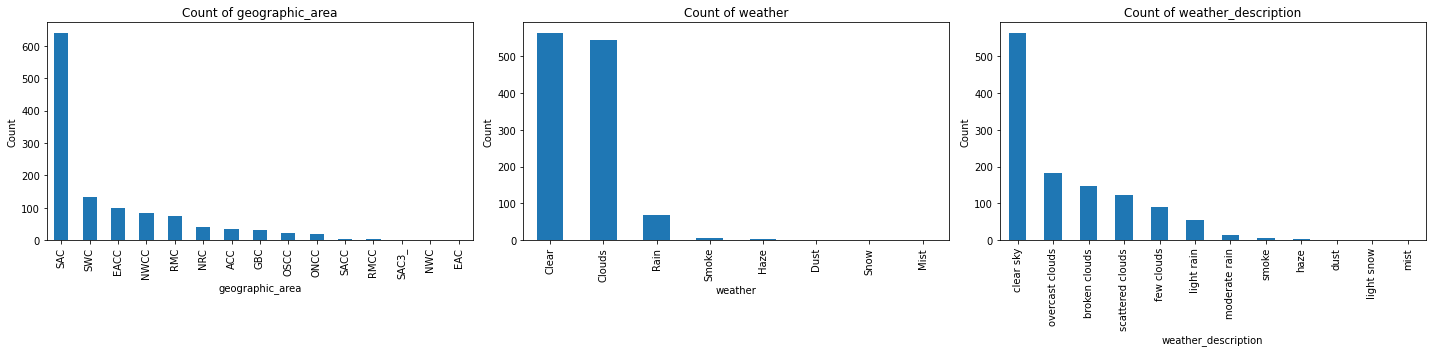

In [26]:
continuous_vars = ['temp', 'humidity', 'wind_speed']
num_cont_vars = len(continuous_vars)

# Create a grid for continuous variables
fig, axes = plt.subplots(nrows=1, ncols=num_cont_vars, figsize=(15, 5))
for i, var in enumerate(continuous_vars):
    df[var].plot(kind='hist', bins=30, alpha=0.7, density=True, edgecolor='black', ax=axes[i])
    df[var].plot(kind='kde', ax=axes[i])
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

# Univariate Analysis - Categorical Variables
categorical_vars = ['geographic_area', 'weather', 'weather_description']
num_cat_vars = len(categorical_vars)

# Create a grid for categorical variables
fig, axes = plt.subplots(nrows=1, ncols=num_cat_vars, figsize=(20, 5))
for i, var in enumerate(categorical_vars):
    df[var].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Count of {var}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(var)
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### Bivariate Analysis

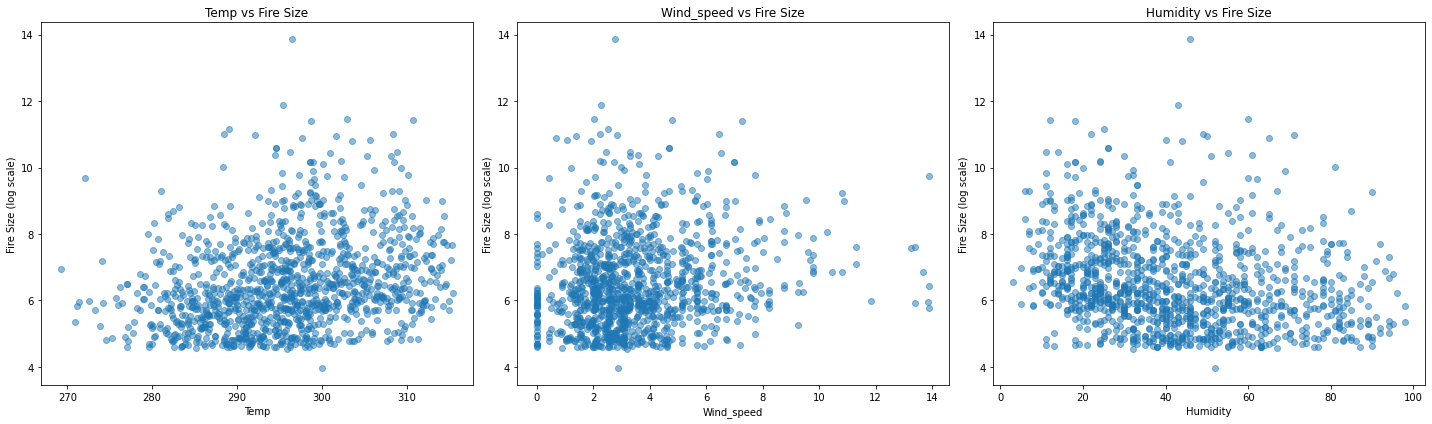

In [36]:
bivariate_vars = ['temp', 'wind_speed', 'humidity']
num_bivariate_vars = len(bivariate_vars)

# Create a grid for bivariate analysis
fig, axes = plt.subplots(nrows=1, ncols=num_bivariate_vars, figsize=(20, 6))

for i, var in enumerate(bivariate_vars):
    axes[i].scatter(df[var], np.log(df['size']), alpha=0.5)
    axes[i].set_title(f'{var.capitalize()} vs Fire Size')
    axes[i].set_xlabel(var.capitalize())
    axes[i].set_ylabel('Fire Size (log scale)')

plt.tight_layout()
plt.show()

### Export geographical fire heatmap

In [39]:
import folium
from folium.plugins import HeatMap

map_center = [df['lat'].mean(), df['lon'].mean()]
fire_map = folium.Map(location=map_center, zoom_start=5)

heat_data = [[row['lat'], row['lon']] for index, row in df.iterrows()]
HeatMap(heat_data).add_to(fire_map)

fire_map.save('fire_map.html')

## Hypothesis Testing

### T-Test

South fire size vs Southern California fire size

In [53]:
california_fires = df[df['geographic_area'] == 'SWC']['size']
other_fires = df[df['geographic_area'] != 'SAC']['size']

# Perform the t-test
t_stat, p_val = ttest_ind(california_fires, other_fires, equal_var=False)
print(f'T-Test: t-statistic={t_stat}, p-value={p_val}')

T-Test: t-statistic=-0.7802710188771791, p-value=0.4358727531126749


### ANOVA

In [58]:
# ANOVA for weather
groups = [group['size'].values for name, group in df.groupby('weather')]

# Perform ANOVA
f_stat, p_val = f_oneway(*groups)
print(f'ANOVA: F-statistic={f_stat}, p-value={p_val}')

ANOVA: F-statistic=0.13175720977151237, p-value=0.995964682149366


In [60]:
# ANOVA for geographic area
groups = [group['size'].values for name, group in df.groupby('geographic_area')]

# Perform ANOVA
f_stat, p_val = f_oneway(*groups)
print(f'ANOVA: F-statistic={f_stat}, p-value={p_val}')

ANOVA: F-statistic=0.19250504545420827, p-value=0.9994901779245264


In [69]:
# ANOVA for geographic area
groups = [group['size'].values for name, group in df.groupby('visibility')]

# Perform ANOVA
f_stat, p_val = f_oneway(*groups)
print(f'ANOVA: F-statistic={f_stat}, p-value={p_val}')

ANOVA: F-statistic=0.25276321218152425, p-value=0.9078464482059281


### Chi-Square

In [59]:
# Chi-Square Test: Test independence between large fires and geographic area
df['large_fire'] = df['size'] > df['size'].median()

contingency_table = pd.crosstab(df['large_fire'], df['geographic_area'])

# Perform chi-square test
chi2, p_val, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-Square Test: chi2-statistic={chi2}, p-value={p_val}')

Chi-Square Test: chi2-statistic=130.50790664371436, p-value=5.395735065612824e-21
